In [56]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
from sys import getsizeof
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import itertools
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc,precision_recall_curve

### READ IN THE CSV FILE

In [2]:
transactions = pd.read_csv('transactions_obf.csv')

In [3]:
labels = pd.read_csv('labels_obf.csv')

### CHECK OUT THE DATA

In [4]:
transactions.head(10)

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500
5,2017-01-01T01:33:23Z,87747828A1,0cc51b98,6b32dc,5968,442,NaN,1,5.94,8500
6,2017-01-01T01:39:19Z,26312005A1,d5a8f4bc,bb3ef2,5968,826,KT11,1,312.72,10500
7,2017-01-01T01:36:52Z,68541785A1,4acaa3e9,f51d17,5968,826,NR1,1,11.00,8500
8,2017-01-01T02:24:10Z,73437030A1,d3a5049c,f24576,5999,442,NaN,1,5.93,500
9,2017-01-01T02:41:12Z,33976065A1,b9b98bc8,7d5803,5499,826,NR1,81,21.00,8500


In [5]:
labels.head(10)

,reportedTime,eventId
0,2017-01-04T00:00:00Z,101536329A1
1,2017-01-04T00:00:00Z,101536425A1
2,2017-01-04T00:00:00Z,101536473A1
3,2017-01-04T00:00:00Z,101536617A1
4,2017-01-04T00:00:00Z,101536761A1
5,2017-01-04T00:00:00Z,101536857A1
6,2017-01-04T00:00:00Z,101536905A1
7,2017-01-04T00:00:00Z,101536953A1
8,2017-01-05T00:00:00Z,104586217A1
9,2017-01-08T00:00:00Z,20197235A1


Check the details of each dataset including the data type objects

In [6]:
transactions.info() #there are 118621 individual observations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118621 entries, 0 to 118620
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transactionTime    118621 non-null  object 
 1   eventId            118621 non-null  object 
 2   accountNumber      118621 non-null  object 
 3   merchantId         118621 non-null  object 
 4   mcc                118621 non-null  int64  
 5   merchantCountry    118621 non-null  int64  
 6   merchantZip        95616 non-null   object 
 7   posEntryMode       118621 non-null  int64  
 8   transactionAmount  118621 non-null  float64
 9   availableCash      118621 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 9.1+ MB


 **Merchant Country are coded with integers and the mcc are also integer data types, as well as posEntry mode and available cash**

**Transaction amount is a float data type which is the amount removed from an account at any point of transaction.**

**There are some null values missing in the transaction data in terms of the merchant zip feature**

In [7]:
"""check if the dataset contains duplicate values"""
transactions.duplicated().any()

False

In [8]:
"""check if the dataset contains null values"""
transactions.isna().any() #it turns out just the merchantzip feature has null values..keep that in mind for now

transactionTime      False
eventId              False
accountNumber        False
merchantId           False
mcc                  False
merchantCountry      False
merchantZip           True
posEntryMode         False
transactionAmount    False
availableCash        False
dtype: bool

In [9]:
"""For the labels dataset"""
labels.info() #There ar 875 cases of fraudulent cases in the dataset and the reported time for these cases.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reportedTime  875 non-null    object
 1   eventId       875 non-null    object
dtypes: object(2)
memory usage: 13.8+ KB


In [10]:
"""Find the number of unique values for each feature in the dataset"""
transactions.nunique()

transactionTime      118105
eventId              118621
accountNumber           766
merchantId            33327
mcc                     361
merchantCountry          82
merchantZip            3260
posEntryMode             10
transactionAmount     16431
availableCash            19
dtype: int64

So far so good,we can pull the features transaction amount, mcc, merchant country, available cash and posEntry mode(this is an important feature, if there is a favourite way fraudsters operate with point of sales system).

In [11]:
"""Check for the autocorrelation of these independent variables"""
transactions.corr() 

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash
mcc,1.000000,-0.092775,0.174846,-0.011087,-0.076448
merchantCountry,-0.092775,1.000000,-0.518626,0.030868,0.068169
posEntryMode,0.174846,-0.518626,1.000000,-0.007927,-0.086346
transactionAmount,-0.011087,0.030868,-0.007927,1.000000,0.063817
availableCash,-0.076448,0.068169,-0.086346,0.063817,1.000000


There seems to be no autocorrelation between all the interesting independent variables so far

In [12]:
labels['label'] = 1

In [13]:
labels.head()

,reportedTime,eventId,label
0,2017-01-04T00:00:00Z,101536329A1,1
1,2017-01-04T00:00:00Z,101536425A1,1
2,2017-01-04T00:00:00Z,101536473A1,1
3,2017-01-04T00:00:00Z,101536617A1,1
4,2017-01-04T00:00:00Z,101536761A1,1


### Merge the labels and transaction dataframes and labels the fraudulent cases = 1 and non-fraudulent cases = 0

In [14]:
new_df = pd.merge(transactions, labels, on =['eventId'], how = 'left')

In [15]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118621 entries, 0 to 118620
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transactionTime    118621 non-null  object 
 1   eventId            118621 non-null  object 
 2   accountNumber      118621 non-null  object 
 3   merchantId         118621 non-null  object 
 4   mcc                118621 non-null  int64  
 5   merchantCountry    118621 non-null  int64  
 6   merchantZip        95616 non-null   object 
 7   posEntryMode       118621 non-null  int64  
 8   transactionAmount  118621 non-null  float64
 9   availableCash      118621 non-null  int64  
 10  reportedTime       875 non-null     object 
 11  label              875 non-null     float64
dtypes: float64(2), int64(4), object(6)
memory usage: 11.8+ MB


In [16]:
new_df.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,label
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,NaN,NaN
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,NaN,NaN
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,NaN,NaN
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,NaN,NaN
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,NaN,NaN


In [17]:
new_df['label'] = new_df['label'].fillna(0.0)

In [18]:
new_df.label.value_counts()

0.0    117746
1.0       875
Name: label, dtype: int64

In [19]:
new_df.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,label
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,NaN,0.0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,NaN,0.0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,NaN,0.0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,NaN,0.0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,NaN,0.0


In [20]:
"""Drop the reportedtime column as it contains a lot of null values"""
%time
new_df.drop(columns = ['reportedTime'], inplace = True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [21]:
"Check the correlation of the new merged dataset"
new_df.corr() #posEntrymode seems to be the best performing variable in terms of pearson correlation

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,label
mcc,1.000000,-0.092775,0.174846,-0.011087,-0.076448,0.007664
merchantCountry,-0.092775,1.000000,-0.518626,0.030868,0.068169,-0.047684
posEntryMode,0.174846,-0.518626,1.000000,-0.007927,-0.086346,0.076059
transactionAmount,-0.011087,0.030868,-0.007927,1.000000,0.063817,0.028863
availableCash,-0.076448,0.068169,-0.086346,0.063817,1.000000,-0.051822
label,0.007664,-0.047684,0.076059,0.028863,-0.051822,1.000000


### DATA VISUALISATIONS

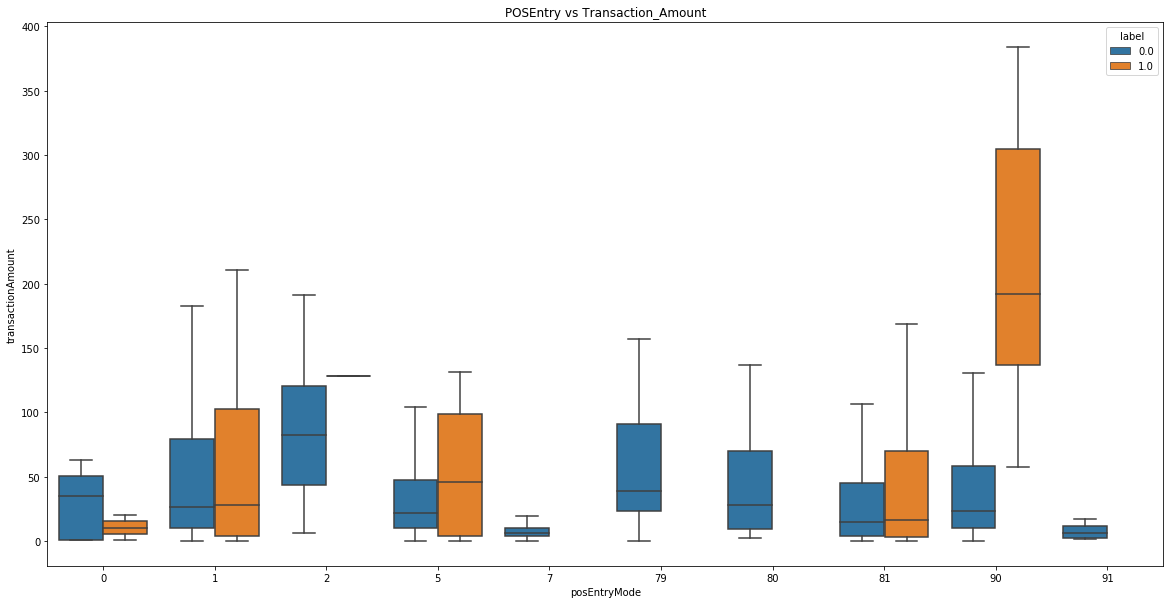

In [22]:
plt.figure(figsize = (20,10))
plt.title('POSEntry vs Transaction_Amount')
sns.boxplot(x = 'posEntryMode', y ='transactionAmount',hue = 'label', data = new_df, 
          showfliers =False)

1.There is a lot money being lost to POS Entry Circuit Card Partial in terms of the fraudulent cases.

2.PosEntryMode values of 07,79,80 and 91 have no fraud cases associated with them

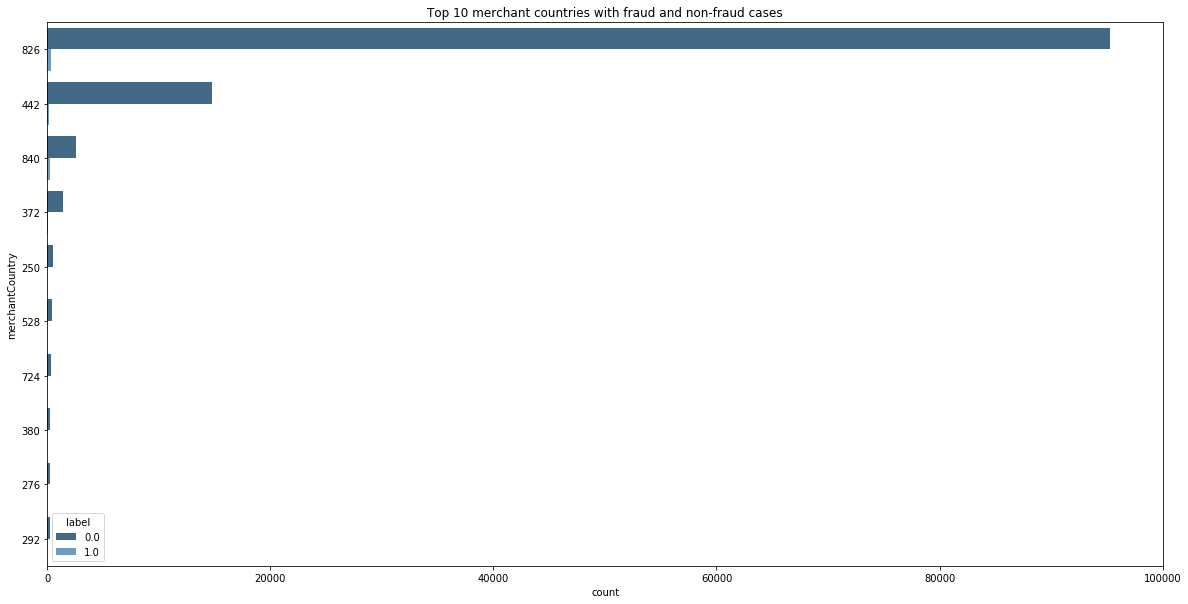

In [23]:
plt.figure(figsize = (20,10))
plt.title("Top 10 merchant countries with fraud and non-fraud cases")
sns.countplot(y = "merchantCountry", hue="label", data = new_df, palette = "Blues_d",
             order = new_df.merchantCountry.value_counts().iloc[:10].index)

**Distribution plot for the whole features in the dataset**

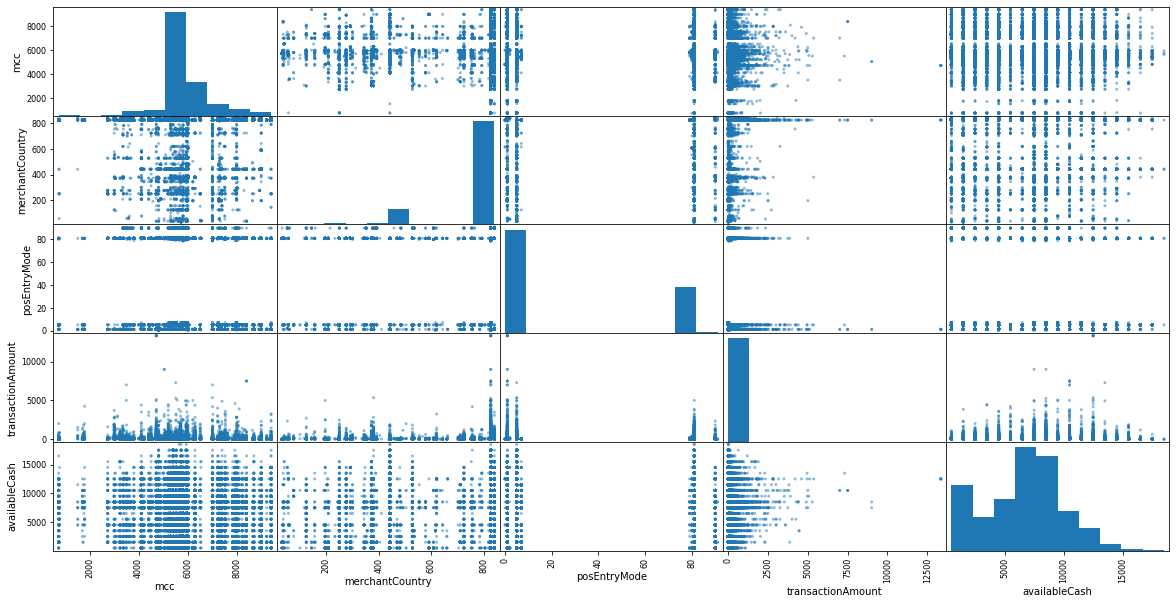

In [24]:
outcome = 'label'
feature_cols = ['mcc', 'merchantCountry', 'posEntryMode', 'transactionAmount', 'availableCash']
pd.plotting.scatter_matrix(new_df[feature_cols], figsize = (20,10));

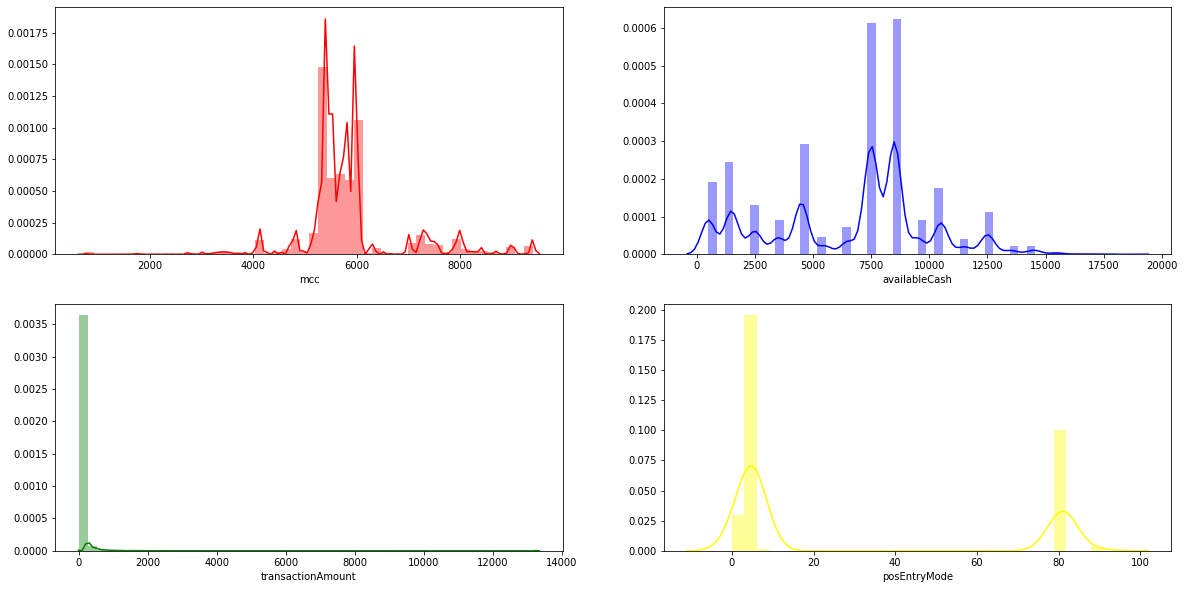

In [25]:
"Plotting the actual distributions of these features"
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.distplot(new_df['mcc'], color = 'red', ax = ax1)
sns.distplot(new_df['availableCash'], color = 'blue', ax = ax2)
sns.distplot(new_df['transactionAmount'], color = 'green', ax = ax3)
sns.distplot(new_df['posEntryMode'], color = 'yellow', ax = ax4);

**Clearly all the distributions including the continuous values are non-normal distributions and will need to be log-transformed and scaled before being put for modelling**

In [26]:
"Computational statistics on the dataset"
new_df.describe()

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,label
count,118621.000000,118621.000000,118621.000000,118621.000000,118621.000000,118621.000000
mean,5834.407272,759.124388,28.552651,53.674774,6625.508974,0.007376
std,976.183515,154.070084,35.647616,183.665315,3410.289486,0.085569
min,742.000000,31.000000,0.000000,-0.150000,500.000000,0.000000
25%,5411.000000,826.000000,5.000000,8.030000,4500.000000,0.000000
50%,5691.000000,826.000000,5.000000,20.250000,7500.000000,0.000000
75%,5967.000000,826.000000,81.000000,49.000000,8500.000000,0.000000
max,9405.000000,840.000000,91.000000,13348.000000,18500.000000,1.000000


In [27]:
new_df['label'] = new_df['label'].astype(int)

In [28]:
print(new_df['transactionTime'].min())
print(new_df['transactionTime'].max())

2017-01-01T00:00:00Z
2018-01-31T00:04:44Z


### EXTRACT MONTH FROM TRANSACTION TIME


In [29]:
"convert date to datetime object"
new_df['transactionTime'] = pd.to_datetime(new_df['transactionTime'])

In [30]:
new_df['transaction_month'] = new_df['transactionTime'].dt.month

In [31]:
new_df.nunique()

transactionTime      118105
eventId              118621
accountNumber           766
merchantId            33327
mcc                     361
merchantCountry          82
merchantZip            3260
posEntryMode             10
transactionAmount     16431
availableCash            19
label                     2
transaction_month        12
dtype: int64

### DATA PRE-PROCESSING

In [32]:
"Seperate the categorical and continous variables"
cat_features = new_df[['transaction_month', 'merchantCountry', 'mcc', 'posEntryMode']]
cont_features = new_df[['transactionAmount','availableCash']]
target = new_df['label']

In [33]:
cat_features = cat_features.applymap(str)

In [34]:
"Log transformation of the continuous variables"
log_cont = (np.log(cont_features + 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2636a5d0>,
      dtype=object)

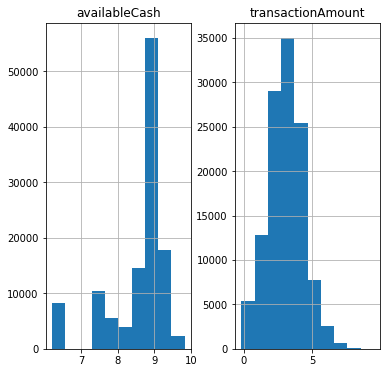

In [35]:
log_cont.hist(figsize = [6,6])

In [36]:
"After normalising the variables, scale the variables using MinMax scaler"
scaler = MinMaxScaler()
scaled_cont = scaler.fit_transform(log_cont)

### FEATUREHASHER FUNCTION ON CATEGORICAL VARIABLES

In [37]:
"Data preprocessing for the categorical variables"
orig_features = cat_features.shape[1]
hash_vector_size = 6
ct = ColumnTransformer([(f't_{i}', FeatureHasher(n_features = hash_vector_size,
                                                input_type ='string'),i) for i in range(orig_features)])

In [38]:
hasher = ct.fit_transform(cat_features)

In [39]:
hasher_df = pd.DataFrame(hasher)

In [40]:
full_df = pd.concat([pd.DataFrame(scaled_cont).reset_index(drop = True), 
                     hasher_df.reset_index(drop=True)],axis = 1
                   )

In [41]:
full_df.head(10) #using the FeatureHasher has sacrificed interpretability

,0,1,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,0.271568,0.749849,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,0.337638,0.608330,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,2.0,0.0,-1.0,0.0,-1.0,0.0,0.0
2,0.202958,0.815341,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0
3,0.336748,0.749849,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,2.0,0.0,-1.0,0.0,-1.0,0.0,0.0
4,0.417495,0.843071,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0
5,0.217334,0.784526,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
6,0.611798,0.843071,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
7,0.274012,0.784526,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
8,0.217185,0.000000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,-1.0,0.0,0.0,0.0,0.0
9,0.336748,0.784526,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,2.0,0.0,-1.0,0.0,-1.0,0.0,0.0


### TRAIN TEST SPLIT AND BASELINE LOGISTIC REGRESSION

In [42]:
X_train,X_test,y_train,y_test = train_test_split(full_df, target, test_size = 0.3, random_state = 42)

In [57]:
"Fitting a baseline logistic regression model"
logreg = LogisticRegressionCV(fit_intercept=False, Cs= 10, solver='liblinear',cv=5)
model_log = logreg.fit(X_train, y_train)
model_log


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=False, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [44]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [45]:
y_train.value_counts()

0    82446
1      588
Name: label, dtype: int64

In [46]:
y_test.value_counts()

0    35300
1      287
Name: label, dtype: int64

In [47]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    82446
1      588
Name: label, dtype: int64
0    0.992919
1    0.007081
Name: label, dtype: float64


In [48]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    35300
1      287
Name: label, dtype: int64
0    0.991935
1    0.008065
Name: label, dtype: float64


### BASELINE REGRESSION MODEL AND CONFUSION MATRIX

The next step is to make use of the confusion matrix to check for the True Positives and the True Negatives of the predicted classes.

In [49]:
""" This function calculates the confusion
    matrix of a classifier model"""
def confusion(cnf_matrix,target):
  plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

# Add appropriate axis scales
  class_names = set(target) # Get class labels to add to matrix
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

# Add labels to each cell
  thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment='center',
             color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
  plt.colorbar()
  plt.show()

Confusion Matrix:
 [[35300     0]
 [  287     0]]


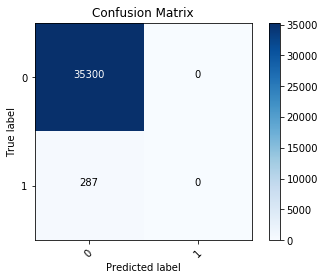

In [50]:
cnf_matrix = confusion_matrix(y_test,y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

confusion(cnf_matrix, target)

Clearly the imbalance of the classes affects the performance of the model drastically as we have 35300 true negatives and 287 false negatives and no single obeservation for the positive cases in the test set

### EVALUATION METRICS FOR BASELINE MODEL PERFORMANCE

In [51]:
print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.0
Testing Precision:  0.0


Training Recall:  0.0
Testing Recall:  0.0


Training Accuracy:  0.9929185634800203
Testing Accuracy:  0.9919352572568635


Training F1-Score:  0.0
Testing F1-Score:  0.0


**Even thou the accuracy is almost 100% because of the imbalanced dataset, this is one of the worst models**

### CLASS IMBALANCE AND WEIGHT CLASSES FOR LOGISTIC REGRESSION MODEL

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.9062743927115515
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.9052992764852781
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20

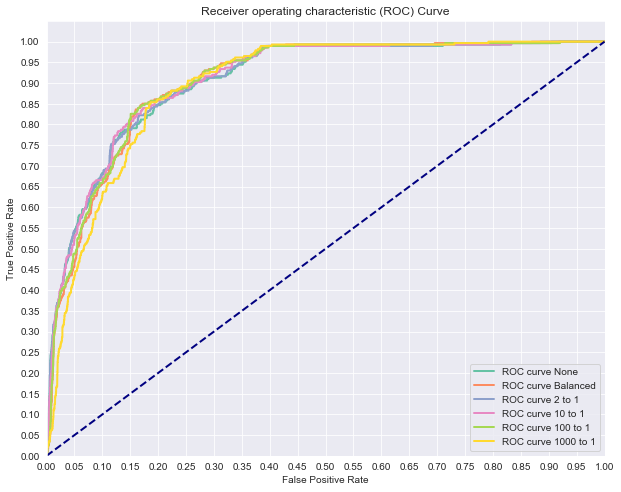

In [58]:
%time
sns.set_style('darkgrid')
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=1e20, class_weight=weight, solver='lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Area under the curve value for 10:1 ratio classes for the positive to negative classes performs with a value of 0.908

### PRECISION RECALL CURVE FOR THE LOGISTIC REGRESSION

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.9 µs
LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.09957995008457321
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.07365316930849432
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, 

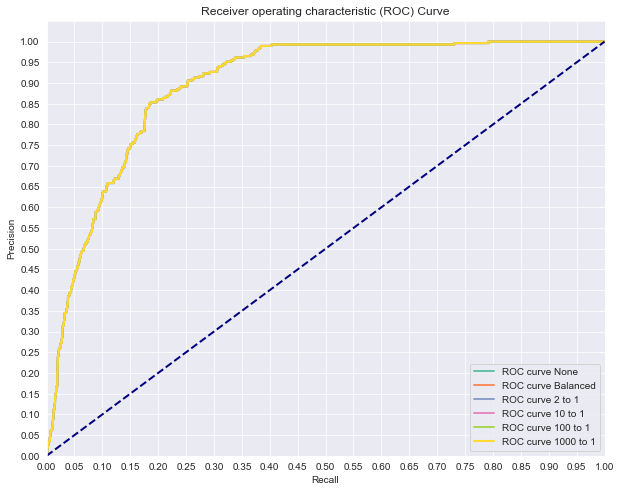

In [59]:
%time
sns.set_style('darkgrid')
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=1e20, class_weight=weight, solver='lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(recall, precision)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The precision-recall curve does not seem to perform as well and the roc-curve metrics..this descrepancy should be investigated further

### SMOTE FOR IMBALANCED DATASET AND VARYING HYPERPARAMETER REGULARISATION

In [60]:
from imblearn.over_sampling import SMOTE
print('Original class distribution: \n')
print(target.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    117746
1       875
Name: label, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    82446
0    82446
dtype: int64


LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.9032209236904186
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.9026973872531118
-------------------------------------------------------
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
           

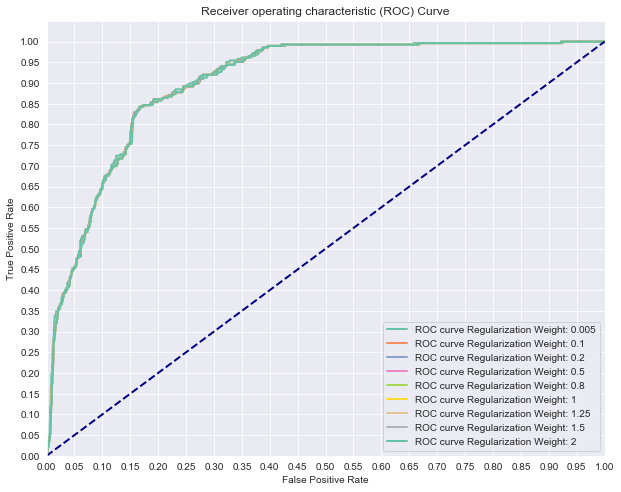

In [61]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Best AUC score with AUC = 0.903 at c-parameter at 0.005 

### BASELINE RANDOM FOREST CLASSIFIER

In [75]:
new_df.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,label,transaction_month
0,2017-01-01 00:00:00+00:00,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0,1
1,2017-01-01 00:49:03+00:00,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0,1
2,2017-01-01 00:43:17+00:00,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,0,1
3,2017-01-01 00:15:07+00:00,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0,1
4,2017-01-01 00:37:09+00:00,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0,1


In [84]:
features = new_df.drop(columns = ['label', 'transactionTime', 'eventId', 'merchantZip','accountNumber','merchantId'])

In [85]:
features.head()

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,transaction_month
0,5968,826,1,10.72,7500,1
1,5499,826,81,21.19,4500,1
2,5735,442,81,5.04,9500,1
3,5499,826,81,21.00,7500,1
4,5411,826,81,47.00,10500,1


In [86]:
Xf_train,Xf_test,yf_train,yf_test = train_test_split(features, target, test_size = 0.3, random_state = 42)

In [87]:
#fitting a baseline Random Forest Classifier to the data
forest = RandomForestClassifier(n_estimators =100,max_depth=5) #number of initialised trees at 100.
forest.fit(Xf_train, yf_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
#Training accuracy score and test accuracy test
print("The training accuracy score is :", forest.score(Xf_train, yf_train))
print("The test accuracy score is :", forest.score(Xf_test, yf_test)) #the results below indicates the model is not overfitting

The training accuracy score is : 0.9929185634800203
The test accuracy score is : 0.9919352572568635


In [97]:
rf_clf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [5, 10,20],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2],
    'min_samples_split': [5,7],
    'min_samples_leaf': [3, 6]
}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(Xf_train, yf_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 99.41%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 20}


In [98]:
rf_train = rf_grid_search.predict(Xf_train)
rf_test = rf_grid_search.predict(Xf_test)

In [99]:
print('Training Precision: ', precision_score(yf_train, rf_train))
print('Testing Precision: ', precision_score(y_test, rf_test))
print('\n\n')

print('Training Recall: ', recall_score(yf_train, rf_train))
print('Testing Recall: ', recall_score(yf_test, rf_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(yf_train, rf_train))
print('Testing Accuracy: ', accuracy_score(yf_test, rf_test))
print('\n\n')

print('Training F1-Score: ', f1_score(yf_train, rf_train))
print('Testing F1-Score: ', f1_score(yf_test, rf_test))

Training Precision:  0.9590909090909091
Testing Precision:  0.9



Training Recall:  0.358843537414966
Testing Recall:  0.2508710801393728



Training Accuracy:  0.9953513018763398
Testing Accuracy:  0.993733666788434



Training F1-Score:  0.5222772277227723
Testing F1-Score:  0.3923705722070845


In [100]:
print(confusion_matrix(yf_test, rf_test))
print(classification_report(yf_test, rf_test))

[[35292     8]
 [  215    72]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     35300
           1       0.90      0.25      0.39       287

    accuracy                           0.99     35587
   macro avg       0.95      0.63      0.69     35587
weighted avg       0.99      0.99      0.99     35587



### PLOT CONFUSION MATRIX FOR THE RANDOM FOREST MODEL

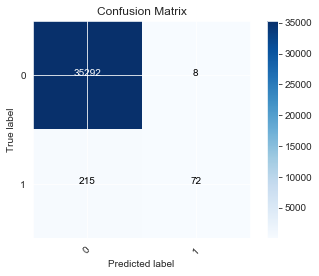

In [110]:
cnf_matrix_2 = confusion_matrix(yf_test, rf_test)
confusion(cnf_matrix_2, target)

### PLOT THE FEATURE IMPORTANCE FOR THE RANDOM FOREST MODEL

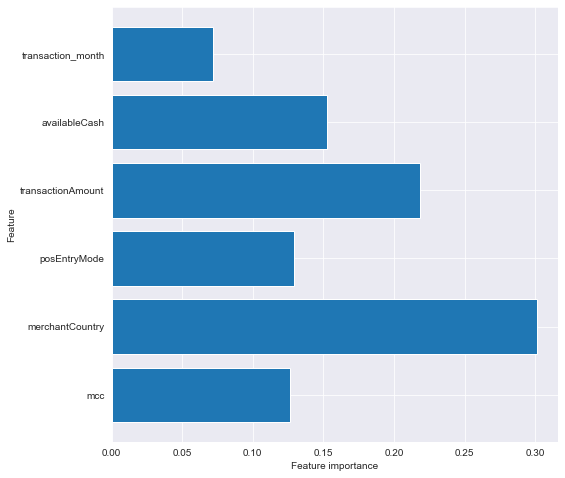

In [101]:
def plot_feature_importances(model):
    n_features = Xf_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), Xf_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest)

### RANDOM FOREST AND SMOTE

In [104]:
Xs_train,Xs_test,ys_train,ys_test = train_test_split(features, target, test_size = 0.3, random_state = 42)


In [105]:
Xs_train_resampled, ys_train_resampled = smote.fit_sample(Xs_train, ys_train)

In [121]:
rf_smote = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [5, 10,20],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2],
    'min_samples_split': [5,7],
    'min_samples_leaf': [3, 6]
}
rf_grid_search_smote = GridSearchCV(rf_smote, rf_param_grid, cv=10)
rf_grid_search_smote.fit(Xs_train_resampled, ys_train_resampled)
print(f"Training Accuracy: {rf_grid_search_smote.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search_smote.best_params_}")

KeyboardInterrupt: 

In [ ]:
rf_train = rf_grid_search_smote.predict(Xs_train_resampled)
rf_test = rf_grid_search_smote.predict(Xs_test)

In [ ]:
print('Training Precision: ', precision_score(ys_train_resampled, rf_train))
print('Testing Precision: ', precision_score(ys_test, rf_test))
print('\n\n')

print('Training Recall: ', recall_score(ys_train_resampled, rf_train))
print('Testing Recall: ', recall_score(ys_test, rf_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(ys_train_resampled, rf_train))
print('Testing Accuracy: ', accuracy_score(ys_test, rf_test))
print('\n\n')

print('Training F1-Score: ', f1_score(ys_train_resampled, rf_train))
print('Testing F1-Score: ', f1_score(ys_test, rf_test))

In [ ]:
cnf_matrix_3 = confusion_matrix(ys_test, rf_test)
confusion(cnf_matrix_3, target)

An improvement on the number of true positive cases predicted in 163 true positive cases and 193 false positive cases

In [122]:
full_df = pd.concat([pd.DataFrame(scaled_cont,columns = ['transaction_amount','available_cash']), 
           hasher_df.reindex(pd.DataFrame(scaled_cont).index)], axis=1)

In [128]:
full_df.shape

(118621, 26)

In [131]:
export_df = pd.concat([full_df,target], axis = 1)

In [132]:
export_df.head()

,transaction_amount,available_cash,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,label
0,0.271568,0.749849,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0
1,0.337638,0.608330,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0
2,0.202958,0.815341,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0
3,0.336748,0.749849,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0
4,0.417495,0.843071,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0


In [133]:
export_df.to_csv('fraud.csv', encoding='utf-8', index =False)